Online retail dataset from UCI: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

Zoha Azimi Ourimi - zoha.azimiourimi@studio.unibo.it

#### Installing required libraries and creating spark session

In [1]:
!pip install pyspark

In [2]:
!pip install findspark

In [3]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-19"
os.environ["SPARK_HOME"] = 'C:\\Users\\Lenovo\\Desktop\\bdavm2\\spark'
findspark.init()
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.master("local").appName("retail").config("spark.executor.memory", "1gb").getOrCreate()

In [5]:
sc = spark.sparkContext

#### Loading the dataset and viweing the first rows

In [6]:
retail_data = spark.read.csv('retail/retail.csv',header = 'True',inferSchema='True')

In [7]:
retail_data.show()

+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|   InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+
| 536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26| 2.55|      17850|United Kingdom|
| 536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26| 3.39|      17850|United Kingdom|
| 536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26| 2.75|      17850|United Kingdom|
| 536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26| 3.39|      17850|United Kingdom|
| 536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26| 3.39|      17850|United Kingdom|
| 536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26| 7.65|      17850|United Kingdom|
| 536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26| 4.25|      17850|United Kingdom|
| 536366|    22633|H

#### Installing and Importing Machine learning libraries

In [8]:
!pip install -U scikit-learn scipy matplotlib pandas seaborn 

In [9]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import  StringIndexer, OneHotEncoder,VectorAssembler,StandardScaler
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
from sklearn.metrics import r2_score
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Changing some column names and datatype conversion

In [10]:
### Datatype conversion
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

data_sparkdf = retail_data.withColumn("Quantity",col("Quantity").cast('integer'))\
            .withColumn("UnitPrice",col("Price").cast('float'))\
            .withColumn('date',to_timestamp("InvoiceDate", 'MM/dd/yy HH:mm'))


data_sparkdf.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- date: timestamp (nullable = true)



In [11]:
data_sparkdf.show(2)

+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+---------+-------------------+
|Invoice|StockCode|         Description|Quantity|   InvoiceDate|Price|Customer ID|       Country|UnitPrice|               date|
+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+---------+-------------------+
| 536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26| 2.55|      17850|United Kingdom|     2.55|2010-12-01 08:26:00|
| 536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26| 3.39|      17850|United Kingdom|     3.39|2010-12-01 08:26:00|
+-------+---------+--------------------+--------+--------------+-----+-----------+--------------+---------+-------------------+
only showing top 2 rows



#### Data Preprocessing

In [12]:
# Drop rows with empty customer IDs
data_sparkdf = data_sparkdf.na.drop(subset=["Customer ID"])
data_sparkdf.count()

406830

In [13]:
# Removing data points with values less than 0
data_sparkdf = data_sparkdf.where(data_sparkdf.Quantity>0).where(data_sparkdf.UnitPrice>0)

In [14]:
# Register as temp table
data_sparkdf.createOrReplaceTempView("retail")

In [15]:
# Number of rows
spark.sql("SELECT COUNT(*) FROM retail").toPandas()

,count(1)
0,397885


#### RFM Model
The RFM model has received much attention and has been widely used in customer relationship management (CRM) and direct marketing due to its simplicity and effectiveness for evaluating a customer’s profitability.
Given a set of transactional records of a business over a certain period of time, Recency indicates how recently a customer made a purchase with the business; Frequency shows how often a customer has purchased; and Monetary indicates the total (or 
average) a customer has spent. Therefore, each customer of the business can characterized by a set of RFM values, and further all the customers can be grouped into meaningful segments based on their RFM values so that various marketing strategies 
can be adopted to different customer groups accordingly. 

In [16]:
# Most earliest & recent purchase date
spark.sql("SELECT MIN(date) earliest,MAX(date) recent FROM retail").toPandas().head(5)

C:\Users\Lenovo\anaconda3\envs\bda\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
C:\Users\Lenovo\anaconda3\envs\bda\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,earliest,recent
0,2010-12-01 08:26:00,2011-12-09 12:50:00


In [17]:
# Create most recent date column
print(spark.sql("SELECT *,MAX(date) OVER(ORDER BY date DESC) from_date FROM retail").toPandas().head(5))
data_sparkdf = spark.sql("SELECT *,MAX(date) OVER(ORDER BY date DESC) from_date FROM retail")

C:\Users\Lenovo\anaconda3\envs\bda\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
C:\Users\Lenovo\anaconda3\envs\bda\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


  Invoice StockCode                     Description  Quantity  \
0  581587     22631        CIRCUS PARADE LUNCH BOX         12   
1  581587     22556  PLASTERS IN TIN CIRCUS PARADE         12   
2  581587     22555       PLASTERS IN TIN STRONGMAN        12   
3  581587     22728       ALARM CLOCK BAKELIKE PINK         4   
4  581587     22727       ALARM CLOCK BAKELIKE RED          4   

       InvoiceDate  Price  Customer ID Country  UnitPrice                date  \
0  12/9/2011 12:50   1.95        12680  France       1.95 2011-12-09 12:50:00   
1  12/9/2011 12:50   1.65        12680  France       1.65 2011-12-09 12:50:00   
2  12/9/2011 12:50   1.65        12680  France       1.65 2011-12-09 12:50:00   
3  12/9/2011 12:50   3.75        12680  France       3.75 2011-12-09 12:50:00   
4  12/9/2011 12:50   3.75        12680  France       3.75 2011-12-09 12:50:00   

            from_date  
0 2011-12-09 12:50:00  
1 2011-12-09 12:50:00  
2 2011-12-09 12:50:00  
3 2011-12-09 12:50:00  
4 

In [18]:
# Calculate the recency score
data_sparkdf = data_sparkdf.withColumn('recency_days',datediff(col("from_date"),col("date"))+1)
data_sparkdf.show(2)

+-------+---------+--------------------+--------+---------------+-----+-----------+-------+---------+-------------------+-------------------+------------+
|Invoice|StockCode|         Description|Quantity|    InvoiceDate|Price|Customer ID|Country|UnitPrice|               date|          from_date|recency_days|
+-------+---------+--------------------+--------+---------------+-----+-----------+-------+---------+-------------------+-------------------+------------+
| 581587|    22631|CIRCUS PARADE LUN...|      12|12/9/2011 12:50| 1.95|      12680| France|     1.95|2011-12-09 12:50:00|2011-12-09 12:50:00|           1|
| 581587|    22556|PLASTERS IN TIN C...|      12|12/9/2011 12:50| 1.65|      12680| France|     1.65|2011-12-09 12:50:00|2011-12-09 12:50:00|           1|
+-------+---------+--------------------+--------+---------------+-----+-----------+-------+---------+-------------------+-------------------+------------+
only showing top 2 rows



In [19]:
# Calculate most recent purchase by customer
data_sparkdf = data_sparkdf.join(data_sparkdf.groupby('Customer ID').agg(min('recency_days').alias('recency')),on='Customer ID',how='left')

data_sparkdf.show(2)

+-----------+-------+---------+--------------------+--------+---------------+-----+-------+---------+-------------------+-------------------+------------+-------+
|Customer ID|Invoice|StockCode|         Description|Quantity|    InvoiceDate|Price|Country|UnitPrice|               date|          from_date|recency_days|recency|
+-----------+-------+---------+--------------------+--------+---------------+-----+-------+---------+-------------------+-------------------+------------+-------+
|      12680| 581587|    22631|CIRCUS PARADE LUN...|      12|12/9/2011 12:50| 1.95| France|     1.95|2011-12-09 12:50:00|2011-12-09 12:50:00|           1|      1|
|      12680| 581587|    22556|PLASTERS IN TIN C...|      12|12/9/2011 12:50| 1.65| France|     1.65|2011-12-09 12:50:00|2011-12-09 12:50:00|           1|      1|
+-----------+-------+---------+--------------------+--------+---------------+-----+-------+---------+-------------------+-------------------+------------+-------+
only showing top 2 row

In [20]:
data_sparkdf = data_sparkdf.join(data_sparkdf.groupby('Customer ID').agg(count('Invoice').alias('frequency')),on='Customer ID',how='inner')

In [21]:
data_sparkdf.show(2)

+-----------+-------+---------+--------------------+--------+--------------+-----+--------------+---------+-------------------+-------------------+------------+-------+---------+
|Customer ID|Invoice|StockCode|         Description|Quantity|   InvoiceDate|Price|       Country|UnitPrice|               date|          from_date|recency_days|recency|frequency|
+-----------+-------+---------+--------------------+--------+--------------+-----+--------------+---------+-------------------+-------------------+------------+-------+---------+
|      17389| 581485|    22617|BAKING SET SPACEB...|      18|12/9/2011 9:38| 4.95|United Kingdom|     4.95|2011-12-09 09:38:00|2011-12-09 12:50:00|           1|      1|      213|
|      17389| 581485|    22768|FAMILY PHOTO FRAM...|      12|12/9/2011 9:38| 9.95|United Kingdom|     9.95|2011-12-09 09:38:00|2011-12-09 12:50:00|           1|      1|      213|
+-----------+-------+---------+--------------------+--------+--------------+-----+--------------+--------

In [22]:
# Calculat total amount spent by each customer in one purchase
data_sparkdf = data_sparkdf.withColumn('TotalValue',col('UnitPrice')*col('Quantity'))

In [23]:
data_sparkdf = data_sparkdf.join(data_sparkdf.groupBy('Customer ID').agg(sum('TotalValue').alias('monetary_value')),on='Customer ID',how='inner')

In [24]:
data_sparkdf.show(2)

+-----------+-------+---------+--------------------+--------+--------------+-----+--------------+---------+-------------------+-------------------+------------+-------+---------+----------+-----------------+
|Customer ID|Invoice|StockCode|         Description|Quantity|   InvoiceDate|Price|       Country|UnitPrice|               date|          from_date|recency_days|recency|frequency|TotalValue|   monetary_value|
+-----------+-------+---------+--------------------+--------+--------------+-----+--------------+---------+-------------------+-------------------+------------+-------+---------+----------+-----------------+
|      17389| 581485|    22617|BAKING SET SPACEB...|      18|12/9/2011 9:38| 4.95|United Kingdom|     4.95|2011-12-09 09:38:00|2011-12-09 12:50:00|           1|      1|      213|      89.1|31833.67953133583|
|      17389| 581485|    22768|FAMILY PHOTO FRAM...|      12|12/9/2011 9:38| 9.95|United Kingdom|     9.95|2011-12-09 09:38:00|2011-12-09 12:50:00|           1|      1|

In [25]:
final_data_sparkdf = data_sparkdf.select(['recency','frequency','monetary_value','Customer ID']).distinct()
final_data_sparkdf.count()

4338

#### Result of RFM model with recency, frequency and monetary score columns

In [26]:
final_data_sparkdf.show(4)

+-------+---------+------------------+-----------+
|recency|frequency|    monetary_value|Customer ID|
+-------+---------+------------------+-----------+
|     51|       30| 598.8299922943115|      17420|
|    107|       84|1431.9299898147583|      16503|
|     17|      302| 5178.960026443005|      15727|
|      1|      213| 31833.67953133583|      17389|
+-------+---------+------------------+-----------+
only showing top 4 rows



#### Second step data processing 

In [27]:
# Assemble features in a single columns
assemble=VectorAssembler(inputCols=['recency','frequency','monetary_value'], outputCol='assembled_features', handleInvalid="skip")
assembled_data_sparkdf =assemble.transform(final_data_sparkdf)

In [28]:
# Standardise features
scale=StandardScaler(inputCol='assembled_features',outputCol='features')
data_scale=scale.fit(assembled_data_sparkdf)
scaled_data_sparkdf =data_scale.transform(assembled_data_sparkdf)

#### Separating train and test splits

In [29]:
(trainingData, testData) = scaled_data_sparkdf.randomSplit([0.8, 0.2],seed = 11)

#### Applying 3 different ML techniques for clustering of customers 

### K MEANS

#### k-means clustering is one of the most popular algorithms in data mining for grouping samples into a certain number of groups (clusters) based on Euclidean similarity measure. in this work, a vector represents a customer’s RFM values in the form a vector, and these vectors are to be assigned to k clusters.

In [30]:
# Find optimum number of clusters
cost ={}

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='features',k=i)
    KMeans_fit=KMeans_algo.fit(trainingData)
    output=KMeans_fit.transform(trainingData)
    cost[i] = KMeans_fit.summary.trainingCost
    print(i)

2
3
4
5
6
7
8
9


In [31]:
cost

{2: 6906.144966667058,
 3: 3818.63493865253,
 4: 3297.5458318531096,
 5: 2275.3169839744305,
 6: 1958.3934982784538,
 7: 1573.142288898547,
 8: 1338.0571101217706,
 9: 1145.706628249468}

<AxesSubplot: >

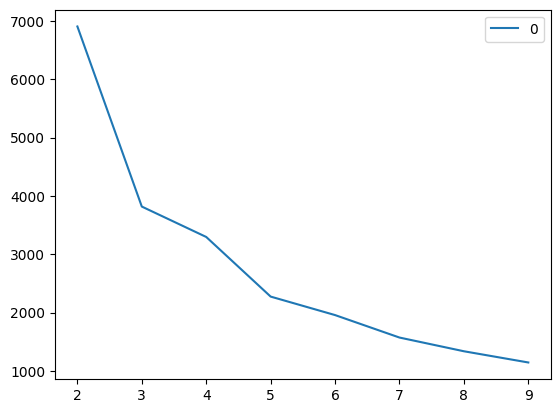

In [32]:
pd.DataFrame.from_dict(cost,orient='index').plot(kind='line')

In [33]:
# using k=4 as the number of nearest neighbors
KMeans_algo=KMeans(featuresCol='features',k=4)
KMeans_fit=KMeans_algo.fit(trainingData)

In [34]:
prediction = KMeans_fit.transform(testData)

In [35]:
result_df = prediction.toPandas()
result_df.head()

,recency,frequency,monetary_value,Customer ID,assembled_features,features,prediction
0,1,54,2085.080013,16954,"[1.0, 54.0, 2085.0800132751465]","[0.009998773726221351, 0.23602940390664534, 0....",0
1,1,71,1316.660006,12526,"[1.0, 71.0, 1316.6600060462952]","[0.009998773726221351, 0.310334956988367, 0.14...",0
2,1,125,1859.310003,12423,"[1.0, 125.0, 1859.3100028038025]","[0.009998773726221351, 0.5463643608950124, 0.2...",0
3,1,157,3641.320016,13426,"[1.0, 157.0, 3641.3200159072876]","[0.009998773726221351, 0.6862336372841356, 0.4...",0
4,1,169,3989.569970,17001,"[1.0, 169.0, 3989.5699696540833]","[0.009998773726221351, 0.7386846159300567, 0.4...",0


In [36]:
from pyspark.ml.evaluation import ClusteringEvaluator

# squared euclidean distance

evaluator = ClusteringEvaluator()
evaluator.evaluate(prediction)



0.7486118329356911

In [37]:
centers = KMeans_fit.clusterCenters()
for center in centers:
    print(center)

[0.42910928 0.44227997 0.20128341]
[2.49814795 0.12295885 0.06071307]
[ 0.02499693 19.0757653  14.54283648]
[ 0.08907998  3.24162942 11.17882683]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18516\506938393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_df = result_df.groupby(['prediction'], as_index=False).mean()


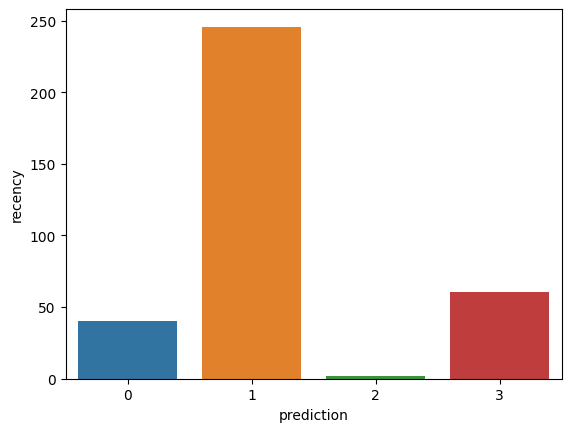

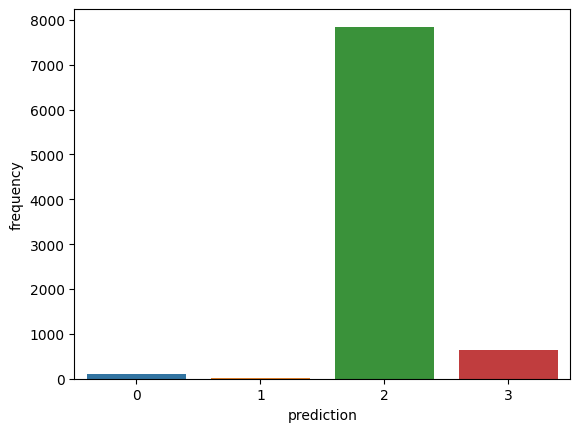

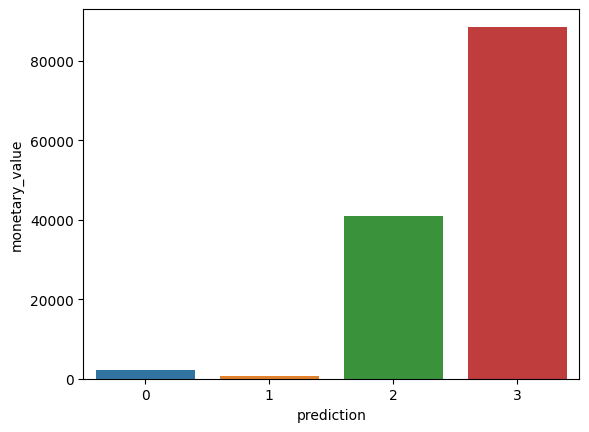

In [38]:
avg_df = result_df.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

### Bisecting k-means

#### Bisecting K-Means Algorithm is a modification of the K-Means algorithm. It is a hybrid approach between partitional and hierarchical clustering. It can recognize clusters of any shape and size.

In [39]:
from pyspark.ml.clustering import BisectingKMeans

bkm = BisectingKMeans().setK(2).setSeed(1)
bkm_model = bkm.fit(trainingData)

In [40]:
bkm_predictions = bkm_model.transform(testData)


In [41]:
from pyspark.ml.evaluation import ClusteringEvaluator

# squared euclidean distance

evaluator_lda = ClusteringEvaluator()
evaluator_lda.evaluate(bkm_predictions)

0.3626216874884191

### Gaussian Mixture Model (GMM)

#### A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. We can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

In [42]:
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture().setK(2).setSeed(2)
gmm_model = gmm.fit(trainingData)

print("Gaussians shown as a DataFrame: ")
gmm_model.gaussiansDF.show(truncate=False)

Gaussians shown as a DataFrame: 
+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean                                                       |cov                                                                                                                                                                                                       |
+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.12191340439008586,2.524194531178163,1.8696031303484248] |0.02008174185152527   -0.07256259600287268  -0.0453794354774016  \n-0.07256259600287268  9.291449408356737     

In [43]:
gmm_predictions = gmm_model.transform(testData)

In [44]:
evaluator = ClusteringEvaluator()
evaluator.evaluate(gmm_predictions)

0.7880849729090835

#### The results show that among the 3 methods of clustering: K means, Bisecting K means and Gaussian Mixture Model, GMM has the best performance. K Means is in the second place very close to GMM, but Bisecting K Means doesn't have a good performance for this task. 